In [1]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime
import statsmodels.tsa as tsa
import statsmodels.api as sm
import statsmodels.graphics.tsaplots as tsaplots
import statsmodels.tsa.stattools as stattools
from scipy import stats
import seaborn as sns
import matplotlib

## Lectura del Dataset

In [2]:
df = pd.read_csv('Dataset/netflix.csv', sep=',')

In [3]:
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2002-05-23,1.242857,1.145714,1.156429,1.196429,104790000.0,1.196429
1,2002-05-24,1.225000,1.197143,1.214286,1.210000,11104800.0,1.210000
2,2002-05-28,1.232143,1.157143,1.213571,1.157143,6609400.0,1.157143
3,2002-05-29,1.164286,1.085714,1.164286,1.103571,6757800.0,1.103571
4,2002-05-30,1.107857,1.071429,1.107857,1.071429,10154200.0,1.071429
...,...,...,...,...,...,...,...
4876,2021-10-05,640.390015,606.890015,606.940002,634.809998,9534300.0,634.809998
4877,2021-10-06,639.869995,626.359985,628.179993,639.099976,4580400.0,639.099976
4878,2021-10-07,646.840027,630.450012,642.229980,631.849976,3556900.0,631.849976
4879,2021-10-08,643.799988,630.859985,634.169983,632.659973,3271100.0,632.659973


Text(0.5, 1.0, 'Precio de la accion de netlix en USD')

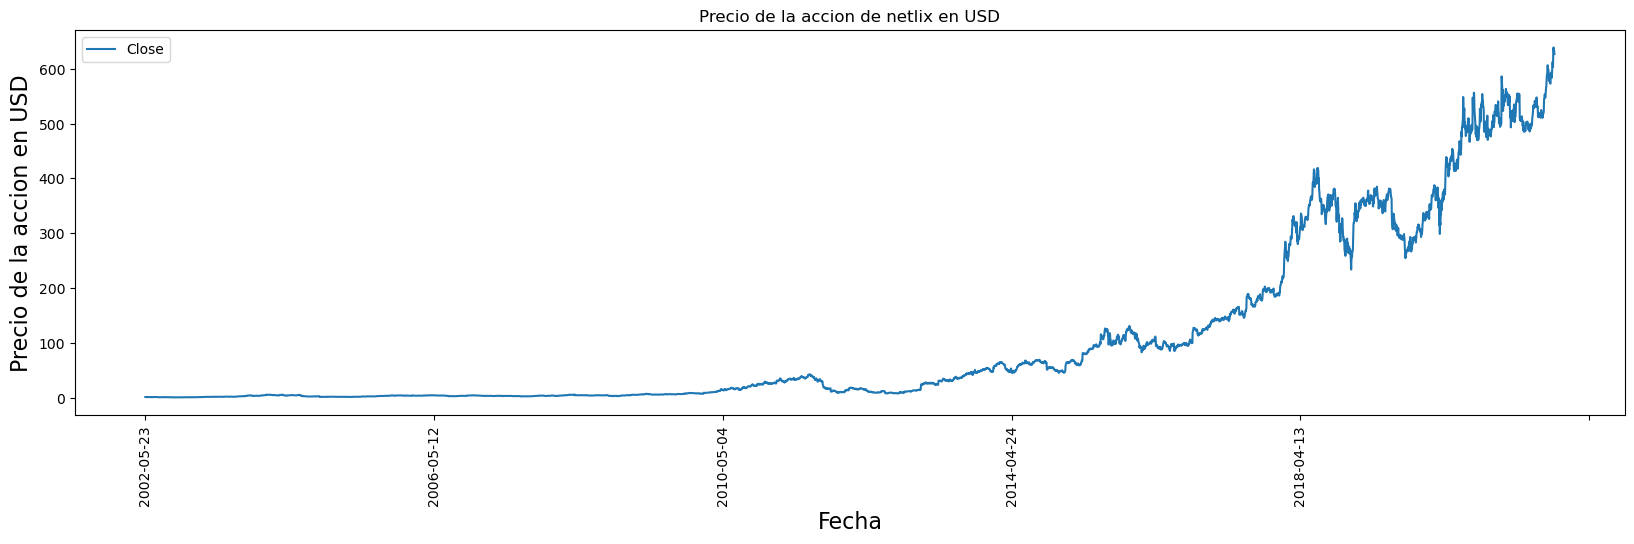

In [4]:
plt.rcParams["figure.figsize"] = (20,5)
ax = df.plot(x="Date",y='Close',rot=90)
ax.set_ylabel("Precio de la accion en USD", fontsize=16)
ax.set_xlabel("Fecha", fontsize=16)
ax.set_title("Precio de la accion de netlix en USD")

No se observa estacionalidad, pero si podemos ver que es creciente a lo largo del tiempo.

# Descompocision usando modelo aditivo

## Additive

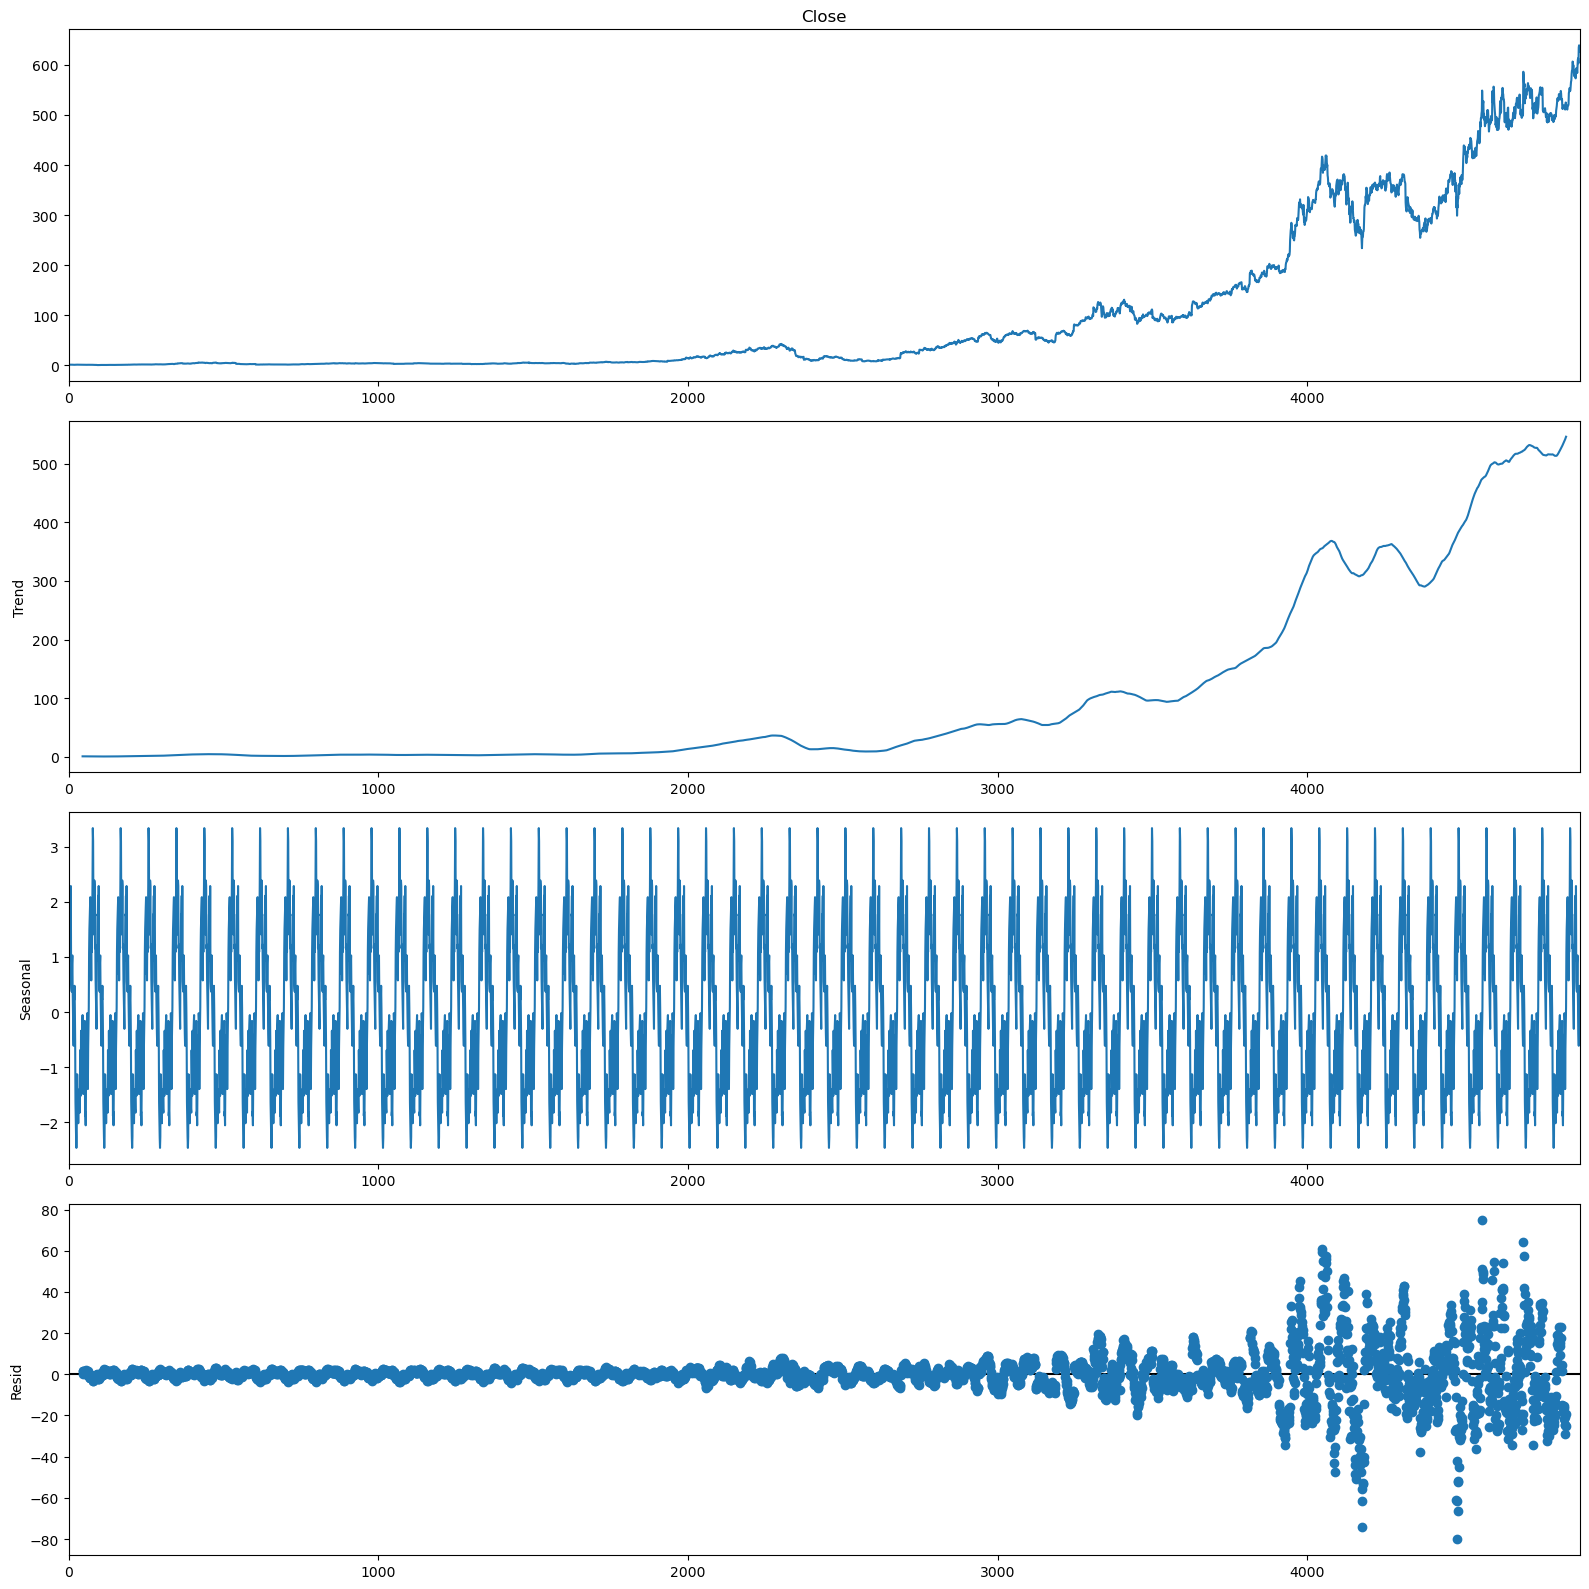

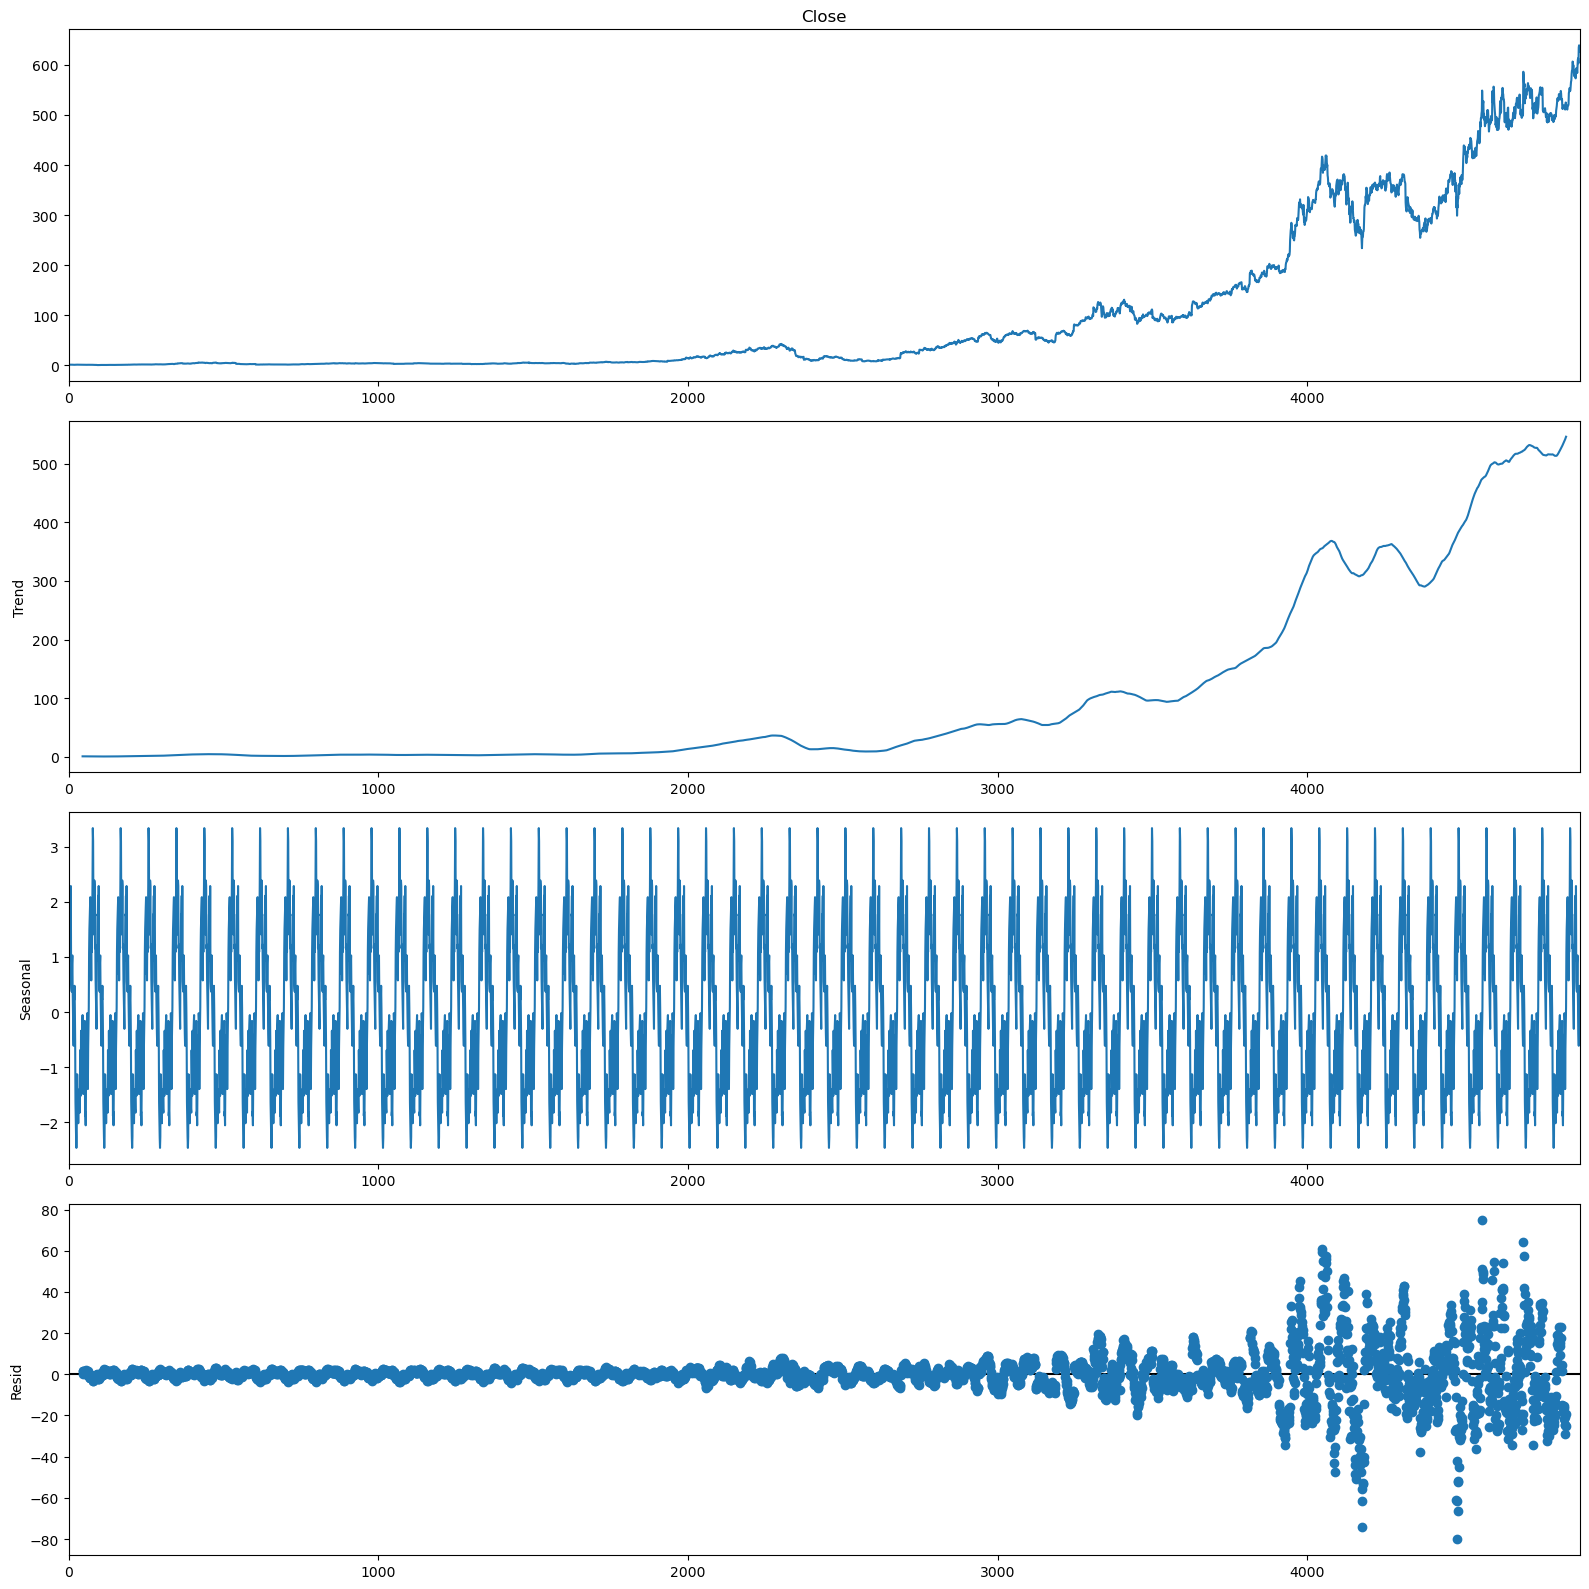

In [5]:
matplotlib.rcParams['figure.figsize'] = [16,16]
period=90
addit=sm.tsa.seasonal_decompose(df["Close"], model='additive', period=period)
addit.plot()

## Multiplicative

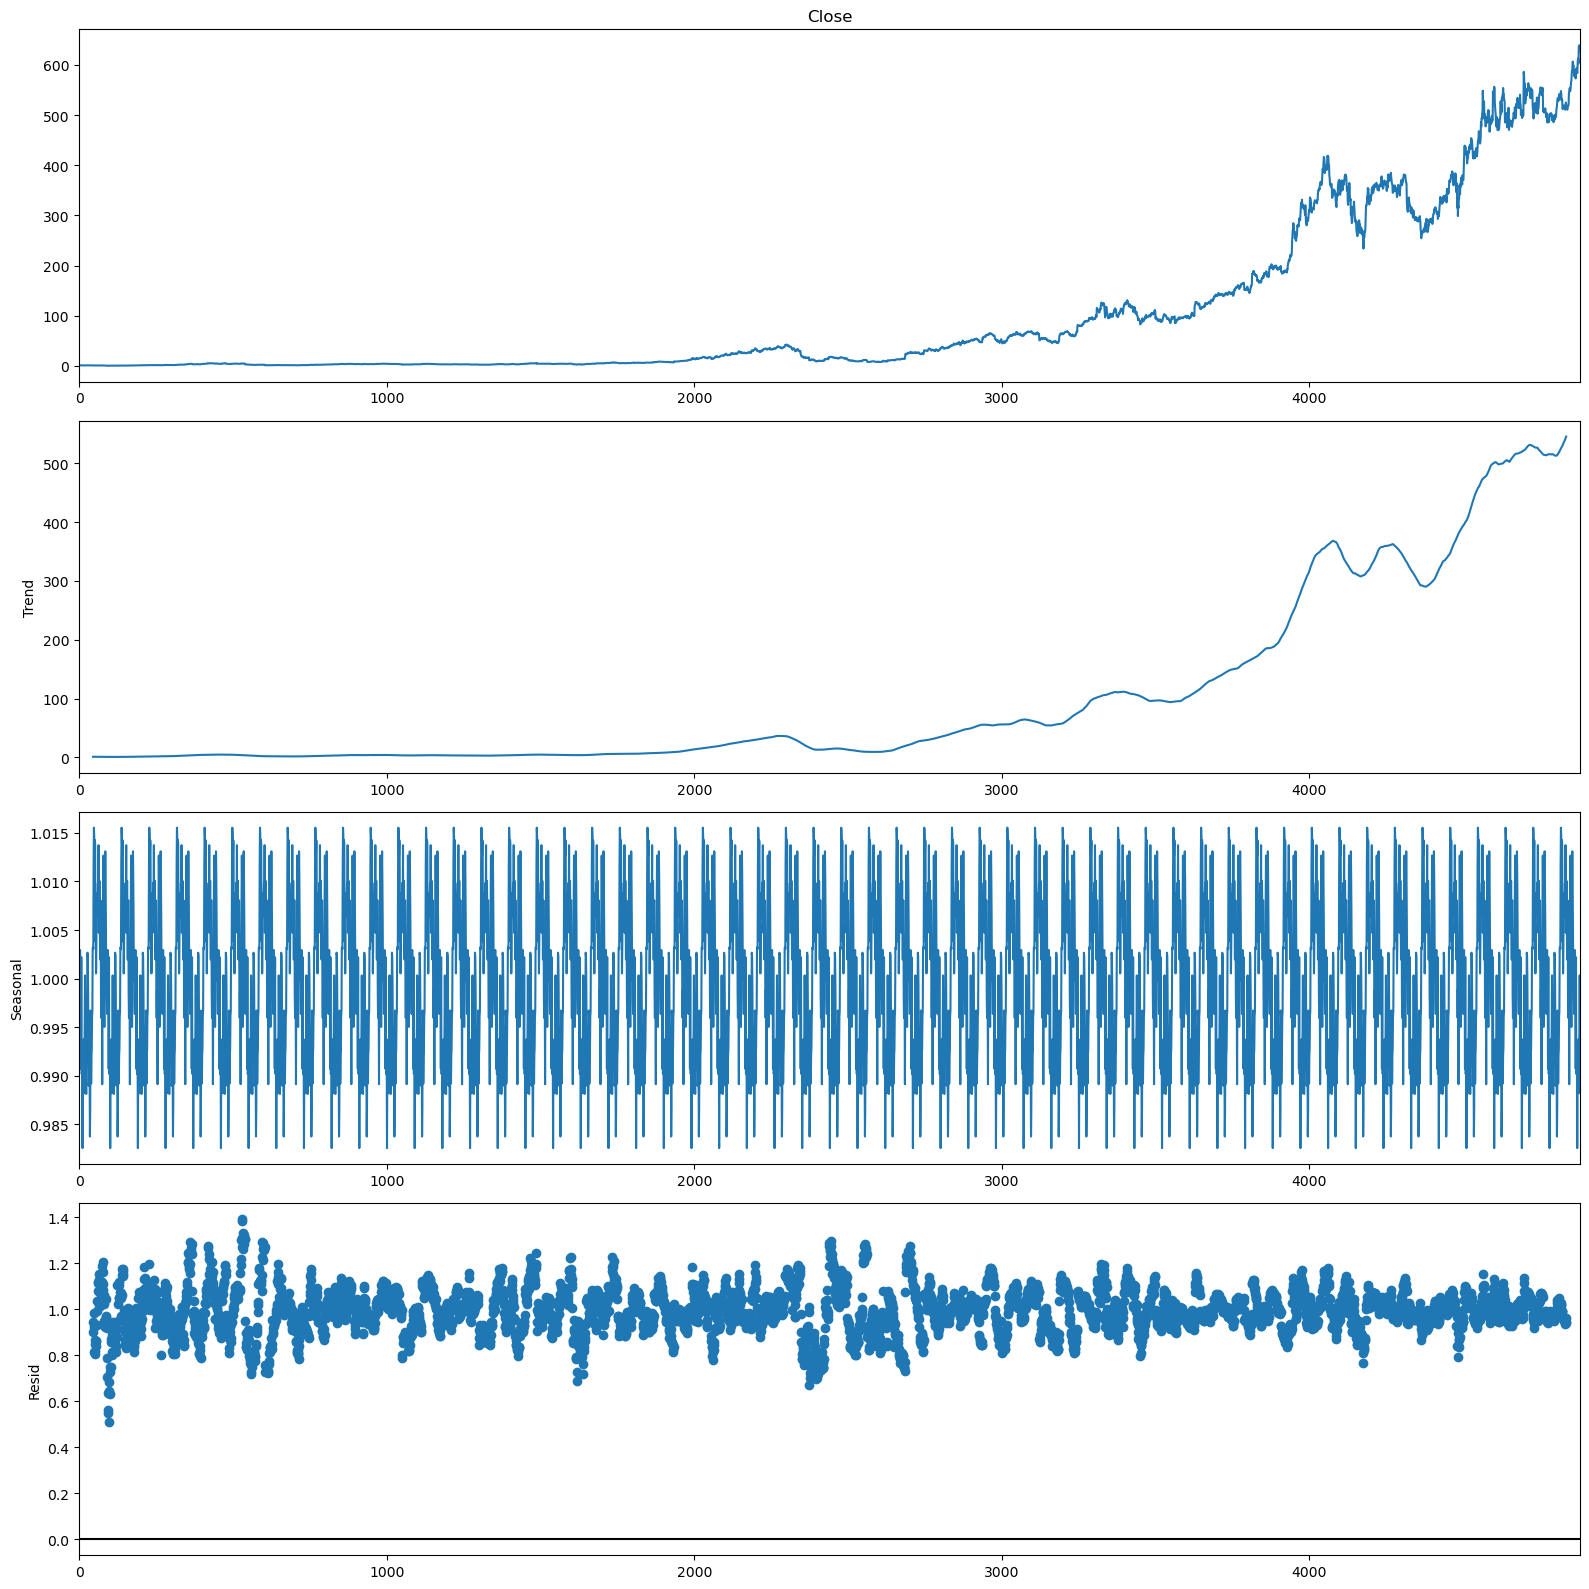

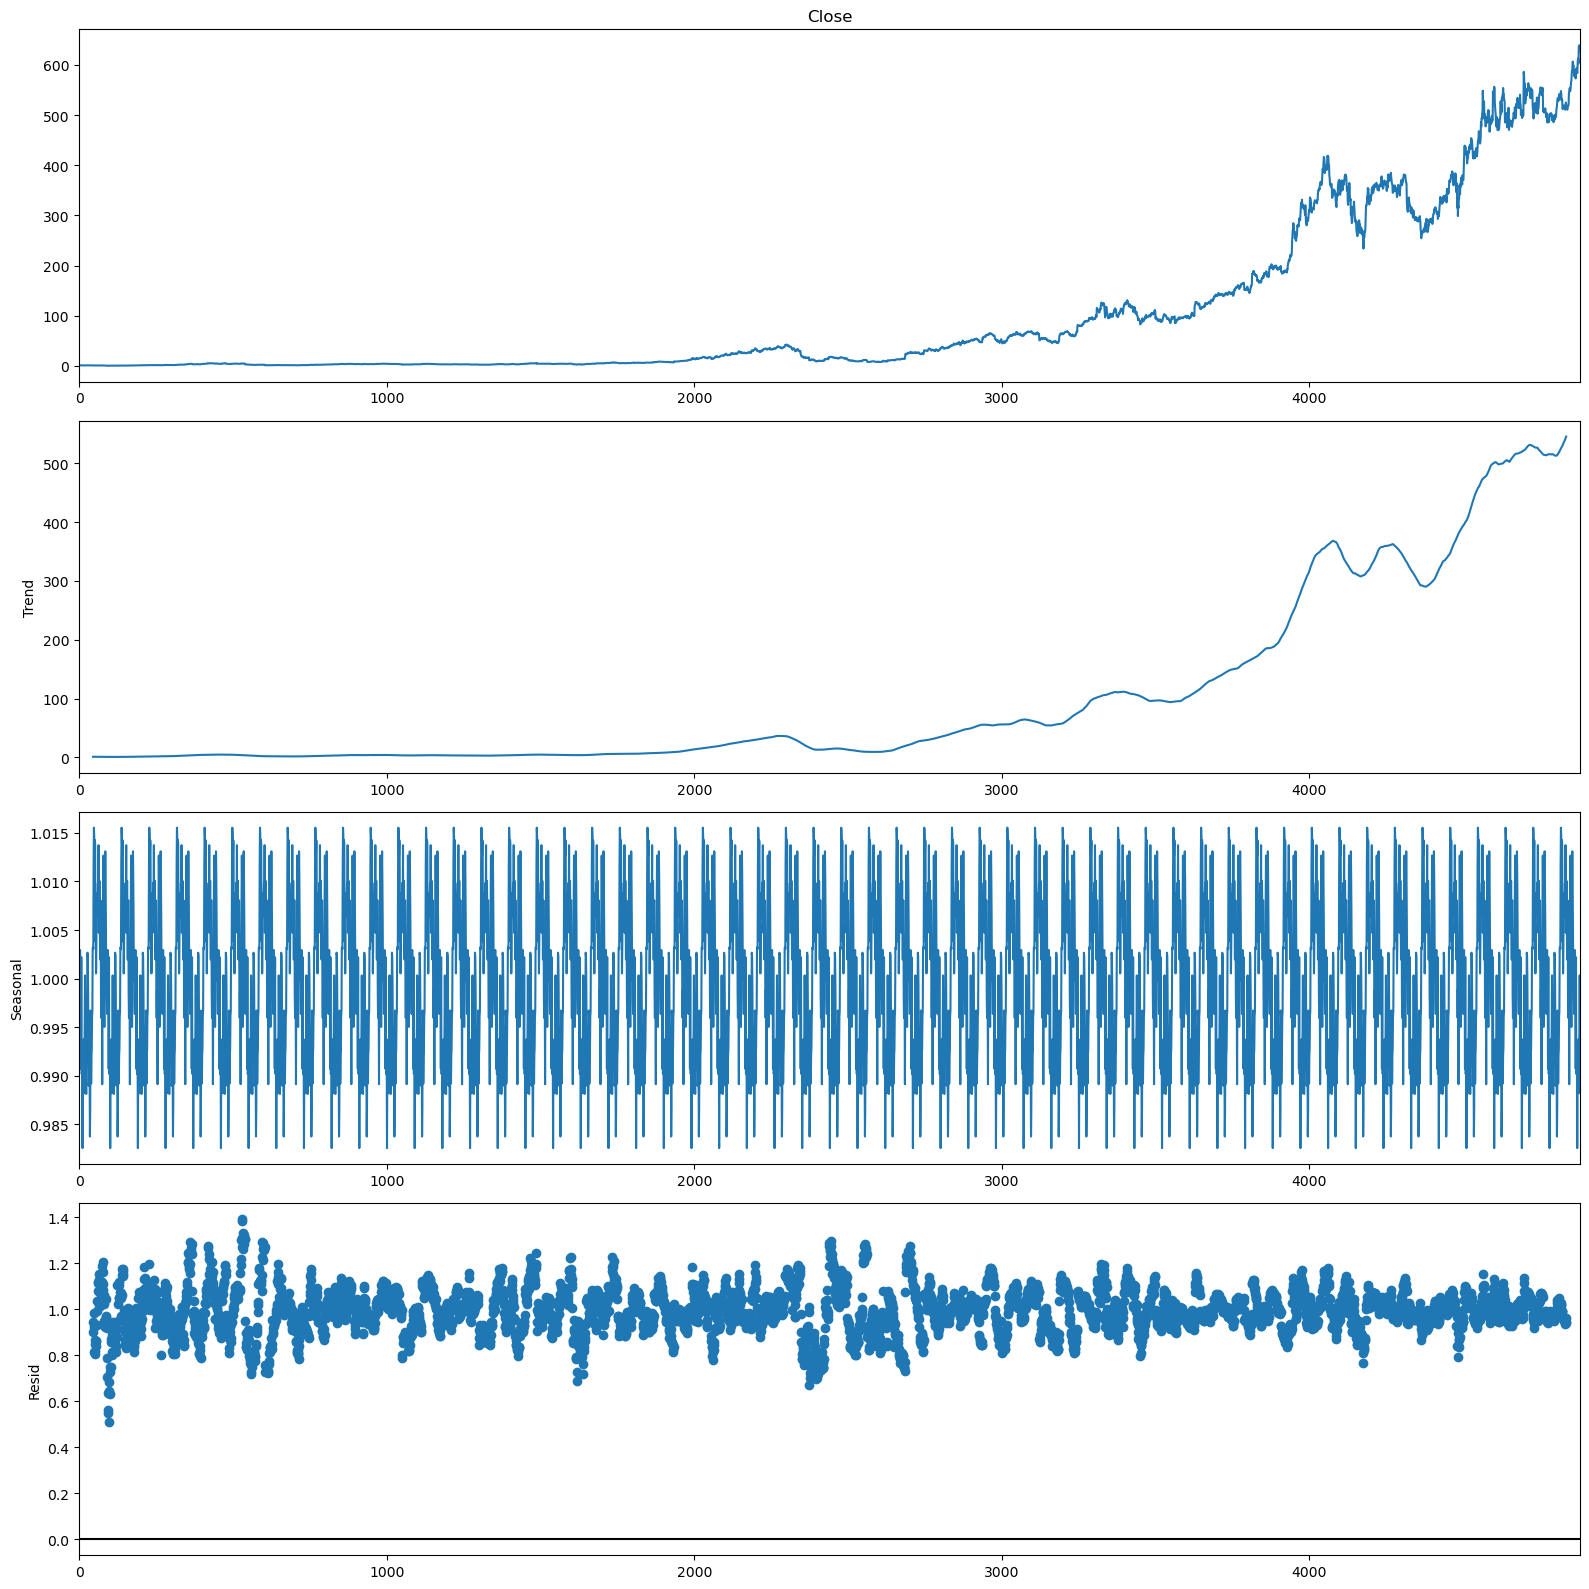

In [6]:
matplotlib.rcParams['figure.figsize'] = [16,16]
mult = sm.tsa.seasonal_decompose(df["Close"] , model='multiplicative', period=period)
mult.plot()

# Extraer Tendendcia

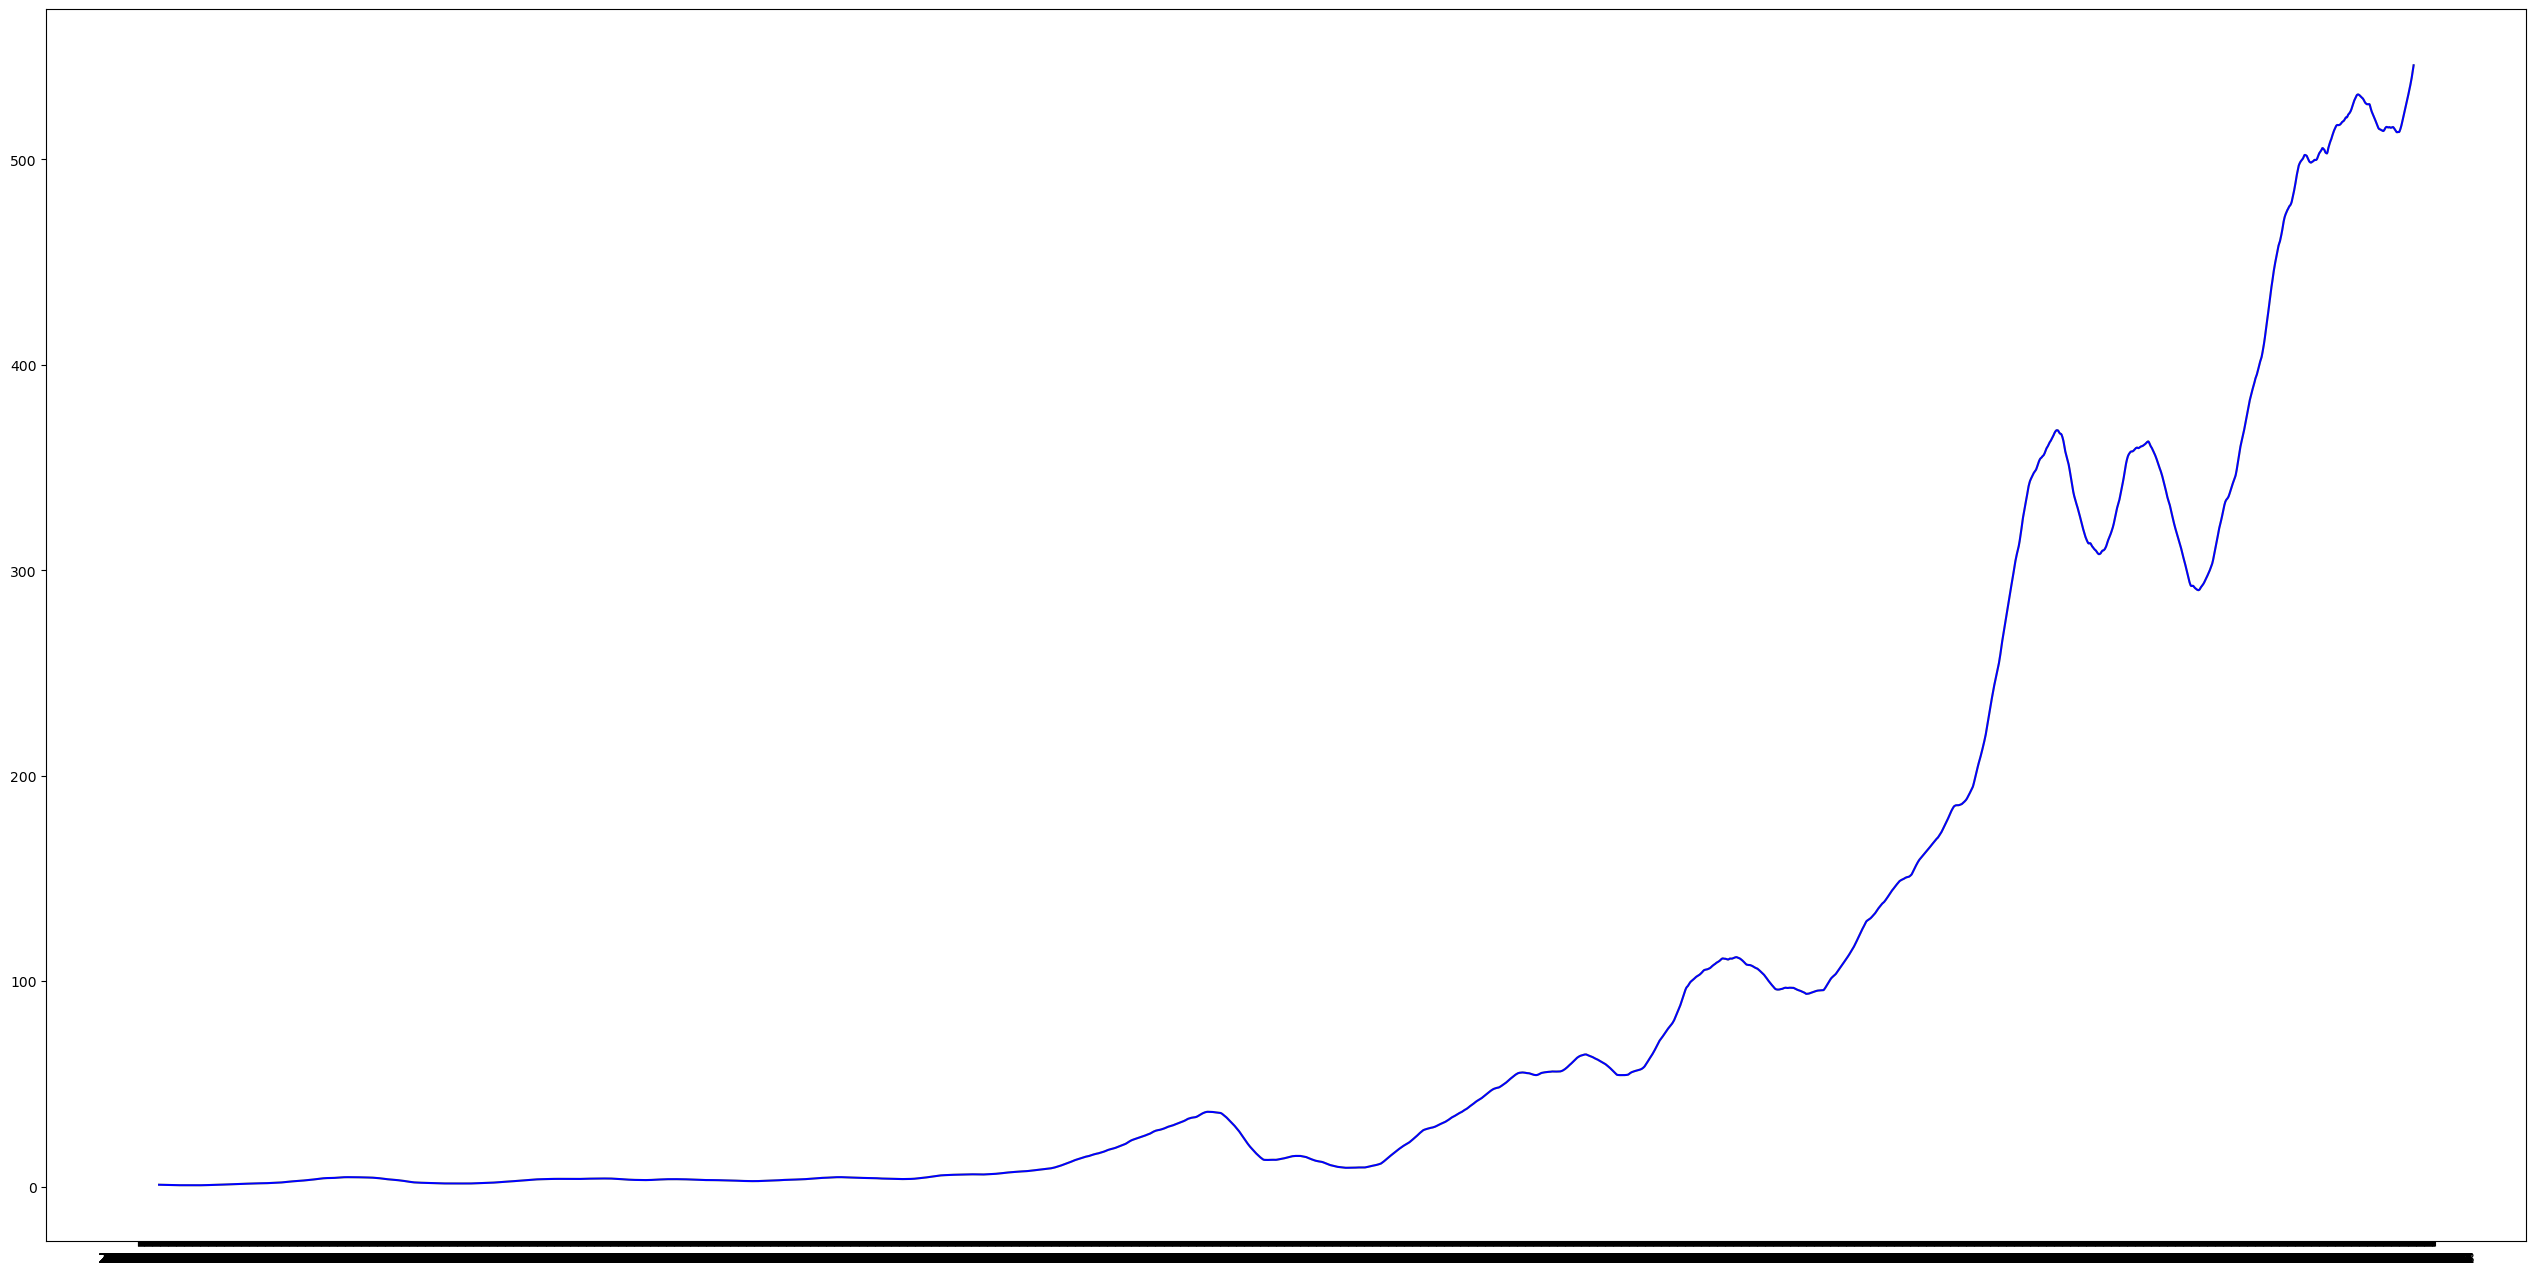

In [7]:
matplotlib.rcParams['figure.figsize'] = [32,16]
period=90
#addit = sm.tsa.seasonal_decompose(df["Close"], model='additive', period=period)
#mult = sm.tsa.seasonal_decompose(df["Close"], model='multiplicative', period=period)
plt.plot(df["Date"],addit.trend, color="yellow")
plt.plot(df["Date"],mult.trend, color="blue")
plt.show()

## Ajustar a un modelo deterministico

In [8]:
z  = np.polyfit(list(range(len(df["Date"]))),list(df["Close"]), 30)

C:\Users\Colo\miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3460: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


In [9]:
p = np.poly1d(z)

In [ ]:
xp = np.linspace(0, len(df["Date"]), len(df["Date"]))


#ax = df.plot(x="Date",y='Close',rot=90)
plt.plot(p(xp))
plt.plot(df["Close"])
plt.plot(df["Date"],mult.trend, color="blue")


plt.show()

Usando polyfit como ajuste, podemos ver que el resultado si bien no es el mejor, se ajusta bastante a la tendencia.

# Clase 4

## Tests de autocorrelacion

In [ ]:
stattools.adfuller(df["Close"])

Basado en el nivel de significancia de 0.05 y el p valor del test de dickey-fuller de 1, no podemos rechazar la hipotesis nula. Por lo tanto segun este test, la serie NO es estacionaria.

In [ ]:
stattools.kpss(df["Close"])

Basado en el nivel de significancia de 0.05 y el p valor del test KPSS de 0.01,podemos rechazar la hipotesis nula. Por lo tanto segun este test, la serie NO es estacionaria.

De acuerdo a la docunmentacion de statsmodels, en este caso, la serie es difference stationary y por lo tanto, debemos aplicar diferenciacion para poder hacerla estacionaria.

In [ ]:
#Aplicacmos differenciacion(el default esta en 1)
df_diff = tsa.statespace.tools.diff(df["Close"],2)

In [ ]:
stattools.adfuller(df_diff)

Basado en el nivel de significancia de 0.05 y el p valor del test de dickey-fuller de 0, podemos rechazar la hipotesis nula. Por lo tanto segun este test, la serie es estacionaria.

In [ ]:
stattools.kpss(df_diff)

Basado en el nivel de significancia de 0.05 y el p valor del test KPSS de 0.1,no podemos rechazar la hipotesis nula. Por lo tanto segun este test, la serie es estacionaria.

## Graficar autocorrelacion

In [ ]:
tsaplots.plot_acf(df_diff, lags=50)

In [ ]:
tsaplots.plot_pacf(df_diff, lags=50);

Usando este grafico de autocorrelacion y autocorrelacion parcial podemos notar que la serie de tiempo no es random y hay correlacion en el mismo.

# Clase 6

## Modelos

In [ ]:
model1 = sm.tsa.statespace.SARIMAX(df_diff, order=(1,0,4), seasonal_order=(0,1,0,2))
fitted_model1 = model1.fit(disp=False)
fitted_model1.summary()

In [ ]:

resid = fitted_model1.resid
resid_norm = (resid-resid.mean())/resid.std()
bins=30

#Plot
fig, ax = plt.subplots(1,4,figsize=(25,10))
resid.plot(ax=ax[0])
ax[0].set_title('Residuals')
sm.qqplot(resid_norm, scale=1, line="45", ax=ax[1])
ax[1].set_title('QQ Plot Residuals')
sm.graphics.tsa.plot_acf(resid, ax=ax[3])
sns.histplot(resid_norm, bins=bins, ax=ax[2])
ax[2].set_title(f'Histograma')

#plt.tight_layout()
plt.show()

In [ ]:
model2 = sm.tsa.statespace.SARIMAX(df_diff, order=(1,0,3), seasonal_order=(0,1,0,2))
fitted_model2 = model2.fit(disp=False)
fitted_model2.summary()

In [ ]:

resid = fitted_model2.resid
resid_norm = (resid-resid.mean())/resid.std()
bins=30

#Plot
fig, ax = plt.subplots(1,4,figsize=(25,10))
resid.plot(ax=ax[0])
ax[0].set_title('Residuals')
sm.qqplot(resid_norm, scale=1, line="45", ax=ax[1])
ax[1].set_title('QQ Plot Residuals')
sm.graphics.tsa.plot_acf(resid, ax=ax[3])
sns.histplot(resid_norm, bins=bins, ax=ax[2])
ax[2].set_title(f'Histograma')

#plt.tight_layout()
plt.show()

In [ ]:
model3 = sm.tsa.statespace.SARIMAX(df_diff, order=(1,0,1), seasonal_order=(0,1,0,2))
fitted_model3 = model3.fit(disp=False)
fitted_model3.summary()

In [ ]:

resid = fitted_model3.resid
resid_norm = (resid-resid.mean())/resid.std()
bins=30

#Plot
fig, ax = plt.subplots(1,4,figsize=(25,10))
resid.plot(ax=ax[0])
ax[0].set_title('Residuals')
sm.qqplot(resid_norm, scale=1, line="45", ax=ax[1])
ax[1].set_title('QQ Plot Residuals')
sm.graphics.tsa.plot_acf(resid, ax=ax[3])
sns.histplot(resid_norm, bins=bins, ax=ax[2])
ax[2].set_title(f'Histograma')

#plt.tight_layout()
plt.show()

## Predicciones

In [ ]:
original_data = df
original_data = original_data.reset_index()

In [ ]:
original_data = df["Close"]-mult.trend
fig, ax = plt.subplots(figsize=[10,5])
ax = original_data.plot(ax=ax, alpha=0.5)
fig = tsaplots.plot_predict(fitted_model1, start=3000, end=6000, ax=ax, plot_insample=False)
# fig = plot_predict(fitted_model2, start=pd.to_datetime('2016-04-26'), end=pd.to_datetime('2017-04-26'), ax=ax, plot_insample=False)

plt.show()

In [ ]:
original_data = df["Close"]-mult.trend
fig, ax = plt.subplots(figsize=[10,5])
ax = original_data.plot(ax=ax, alpha=0.5)
fig = tsaplots.plot_predict(fitted_model2, start=3000, end=6000, ax=ax, plot_insample=False)
# fig = plot_predict(fitted_model2, start=pd.to_datetime('2016-04-26'), end=pd.to_datetime('2017-04-26'), ax=ax, plot_insample=False)

plt.show()

In [ ]:
original_data = df["Close"]-mult.trend
fig, ax = plt.subplots(figsize=[10,5])
ax = original_data.plot(ax=ax, alpha=0.5)
fig = tsaplots.plot_predict(fitted_model3, start=3000, end=6000, ax=ax, plot_insample=False)
# fig = plot_predict(fitted_model2, start=pd.to_datetime('2016-04-26'), end=pd.to_datetime('2017-04-26'), ax=ax, plot_insample=False)

plt.show()

Se puede observar que todos los modelos ajustan bien a la serie, lo unico es que en el modelo 3, el intervalo de confianza del 95% crece de manera desmedida, por lo tanto, probablemente sea el unico que no recomendaria usar.

## LSTM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 

In [ ]:
df3 = df.copy()
df3 = df3.reset_index()
df3['Date'] = df3['Date'].astype('datetime64')

df3 = (
                df3
                .assign(day = df3['Date'].dt.day)
                .assign(month = df3['Date'].dt.month)
                .assign(day_of_week = df3['Date'].dt.dayofweek) 
                .assign(year = df3['Date'].dt.year)
              )

df3.drop(['Date'], axis=1, inplace=True)

df3.head()

In [ ]:
y = df3["Close"]
X = df3.drop(columns=["High","Low","Open","Close","Volume","Adj Close"])

X = X.drop(columns=["index"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)

In [ ]:
X

In [ ]:
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_val_sc = scaler.transform(X_val)
X_test_sc = scaler.transform(X_test)

scalerY = StandardScaler()
y_train_sc = scalerY.fit_transform(np.array(y_train).reshape(-1, 1))
y_val_sc = scalerY.transform(np.array(y_val).reshape(-1, 1))
y_test_sc = scalerY.transform(np.array(y_test).reshape(-1, 1))

In [ ]:
X_train_sc

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
tf.config.set_visible_devices([], 'GPU')

In [ ]:
X_train_sc.shape

In [ ]:
x_train2 = X_train_sc.reshape(-1, 1, 4)
x_test2  = X_test_sc.reshape(-1, 1, 4)
x_val2  = X_val_sc.reshape(-1, 1, 4)
y_train2 = y_train_sc.reshape(-1, 1, 1)
y_test2 = y_test_sc.reshape(-1, 1, 1)
y_val2 = y_val_sc.reshape(-1, 1, 1)


In [ ]:
# Model configuration
batch_size = 64
number_of_epochs = 5000
optimizer = Adam(learning_rate=0.0005)
validation_split = 0.10
verbosity_mode = 1

In [ ]:
# Load dataset
print(x_train2.shape)
print(x_test2.shape)

# Define the Keras model
model = Sequential()
model.add(LSTM(25,input_shape=(1, 4),return_sequences=True))
model.add(LSTM(25,input_shape=(1, 4),return_sequences=False))
model.add(Dense(256, activation='linear'))
model.add(Dense(1, activation='linear'))




callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)


# Compile the model
model.compile(optimizer=optimizer, loss='mse')

In [ ]:
# Give a summary
model.summary()

In [ ]:
# Train the model
history = model.fit(x_train2, y_train2, batch_size=batch_size, epochs=number_of_epochs, verbose=verbosity_mode, callbacks=[callback], validation_data= (x_val2,y_val2)) 

# Test the model after training


In [ ]:
test_results = model.predict(x_test2)
print(np.sum(test_results-y_test2))
test_results[250],y_test2[250]
plt.plot(test_results)
plt.plot(y_test2.reshape(-1,1))

In [ ]:
test_results = model.predict(x_train2)
plt.plot(test_results)
plt.plot(y_train2.reshape(-1,1))

In [ ]:
test_results = model.predict(x_val2)
plt.plot(test_results)
plt.plot(y_val2.reshape(-1,1))

Extrañamente, el modelo de LSTM no puede hacer el un fit con el cual estemos contentos, lo que vemos en los modelos ARIMA es superior en cuanto a fitteo. Se probaron multiples redes y tras multiples horas se decidio quedrse con esta que fue la que mejor resutlado dio. 
Por lo que se ve al modelo le cuesta hacer fit debido a la fuerte subida que tiene la accion es un muy corto periodio de tiempo en 2018 y 2019.

## Analisis espectral

In [ ]:
from scipy import signal

In [ ]:
f, px = signal.periodogram(df["Close"],len(df))
plt.figure(figsize=(18,5))
plt.plot(f, px)
plt.title('Periodograma')
plt.xlabel('Frecuencia')
plt.ylabel('Densidad Espectral de Potencia')

In [ ]:
N = 20
f, px = signal.periodogram(df["Close"][0:10], N)
plt.figure(figsize=(18,5))
plt.plot(f, px)
plt.title('Periodograma')
plt.xlabel('Frecuencia')
plt.ylabel('Densidad Espectral de Potencia')